In [1]:
#Sources used: https://towardsdatascience.com/transfer-learning-from-pre-trained-models-f2393f124751
#              https://medium.com/@ODSC/how-to-leverage-pre-trained-layers-in-image-classification-31fb9b8cdd0
#              https://towardsdatascience.com/a-comprehensive-hands-on-guide-to-transfer-learning-with-real-world-applications-in-deep-learning-212bf3b2f27a
#Also based this a lot on the work of the other teammates too :)
import numpy as np
import pandas as pd
import json 
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow
import keras
from keras.applications import vgg16, inception_v3, resnet50, mobilenet
from keras import models
# imports for loading and viewing image 
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.imagenet_utils import decode_predictions
# encode text category labels
from sklearn.preprocessing import LabelEncoder

In [2]:
import glob
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
def toString(arr):
  return [str(elem) for elem in arr]

In [5]:
df = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/Memes Project/dank_image_downloaded.csv")
df['ups_normed'] = df['ups']/df['subscribers']

value = df['ups_normed'].quantile(0.95)
df['dank_level'] = df['ups_normed'].apply(lambda x: 1 if x >= value else 0)

def getDankLevel(imageLink):
  imgID = imageLink.split('/')[-1].split('.')[0] #find image id based on the file name
  return list(df.loc[df['id'] == imgID]['dank_level'])[0] #look up the dank_level based on the image id

data = '/content/gdrive/My Drive/Colab Notebooks/Memes Project/data'
train_files = glob.glob(data + '/training/*.jpg')
validation_files = glob.glob(data + '/validation/*.jpg')
test_files = glob.glob(data + '/test/*.jpg')
print("Training: {} imgs, Validation: {} imgs, Test: {} imgs".format(len(train_files), len(validation_files), len(test_files)))

IMG_DIM = (224, 224)
train_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in train_files]
train_imgs = np.array(train_imgs)

validation_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in validation_files]
validation_imgs = np.array(validation_imgs)
"""
test_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in test_files]
test_imgs = np.array(test_imgs)
"""
print('Train dataset shape:', train_imgs.shape, 
      '\tValidation dataset shape:', validation_imgs.shape)

"""
test_imgs_scaled = test_imgs.astype('float32')
test_imgs_scaled /= 255 
"""

train_labels = [getDankLevel(fn) for fn in train_files]
validation_labels = [getDankLevel(fn) for fn in validation_files]
#test_labels = [getDankLevel(fn) for fn in test_files]

print("Generated the labels ", train_labels[0:5], " ", validation_labels[0:5])

le = LabelEncoder()
le.fit(train_labels)
train_labels_enc = le.transform(train_labels)
validation_labels_enc = le.transform(validation_labels)
#test_labels_enc = le.transform(test_labels)

print("Encoded the labels ", train_labels_enc[0:5], " ", validation_labels_enc[0:5])

# Image Augmentation generator to create variety of images
train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, rotation_range=50,
                                  width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, 
                                  horizontal_flip=True, fill_mode='nearest')
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(train_imgs, train_labels_enc, batch_size=30)
val_generator = val_datagen.flow(validation_imgs, validation_labels_enc, batch_size=20)  

print("Created the generator")   

Training: 3712 imgs, Validation: 1856 imgs, Test: 1858 imgs
Train dataset shape: (3712, 224, 224, 3) 	Validation dataset shape: (1856, 224, 224, 3)
Generated the labels  [0, 0, 0, 0, 0]   [0, 0, 0, 0, 0]
Encoded the labels  [0 0 0 0 0]   [0 0 0 0 0]
Created the generator


In [6]:
"""        
layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable']).tail(10)   
"""

"        \nlayers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]\npd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable']).tail(10)   \n"

In [7]:
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers
from tensorflow.keras.optimizers import SGD, Adam, RMSprop, Adagrad
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

vgg = vgg16.VGG16(include_top=False, weights='imagenet', 
                                  input_shape=(224, 224, 3))

output = vgg.layers[-1].output
output = keras.layers.Flatten()(output)
vgg_model = Model(vgg.input, output)

vgg_model.trainable = False
for layer in vgg_model.layers:
    layer.trainable = False   

#unfreeze some layers
vgg_model.trainable = True

retrain_layers = ['block5_conv1', 'block4_conv1']
set_trainable = False
for layer in vgg_model.layers:
    if layer.name in retrain_layers:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
        
input_shape = vgg_model.output_shape[1]

model = Sequential()
model.add(vgg_model)
model.add(InputLayer(input_shape=(input_shape,)))
model.add(Dense(512, activation='relu', input_dim=input_shape))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['accuracy'])

# to prevent over fitting training will stop after 20 epochs if val_loss value not decreased
earlystop = EarlyStopping(patience=20)
# reduce the learning rate when then accuracy not increases for 3 steps
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.75, 
                                            min_lr=1e-20)
callbacks = [earlystop, learning_rate_reduction]

STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = val_generator.n//val_generator.batch_size

history = model.fit_generator(train_generator, steps_per_epoch=STEP_SIZE_TRAIN, epochs=100, 
                              validation_data=val_generator, validation_steps=STEP_SIZE_VALID, callbacks=callbacks, verbose=1)     

58892288/58889256 [==============================] - 2s 0us/step
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
123/123 [==============================] - 55s 448ms/step - loss: 0.7077 - accuracy: 0.5084 - val_loss: 0.6902 - val_accuracy: 0.5342
Epoch 2/100
123/123 [==============================] - 54s 436ms/step - loss: 0.6943 - accuracy: 0.5339 - val_loss: 0.6915 - val_accuracy: 0.5375
Epoch 3/100
123/123 [==============================] - 54s 438ms/step - loss: 0.6907 - accuracy: 0.5424 - val_loss: 0.7263 - val_accuracy: 0.5217
Epoch 4/100
123/123 [==============================] - 54s 441ms/step - loss: 0.6941 - accuracy: 0.5348 - val_loss: 0.6904 - val_accuracy: 0.5147
Epoch 5/100
123/123 [==============================] - 54s 439ms/step - loss: 0.6924 - accuracy: 0.5413 - val_loss: 0.6882 - val_accuracy: 0.5511
Epoch 6/100
123/123 [==============================] - 54s 439ms/step - loss: 0.6869 - accuracy: 0.5530 - val_loss: 0.6771 - val_

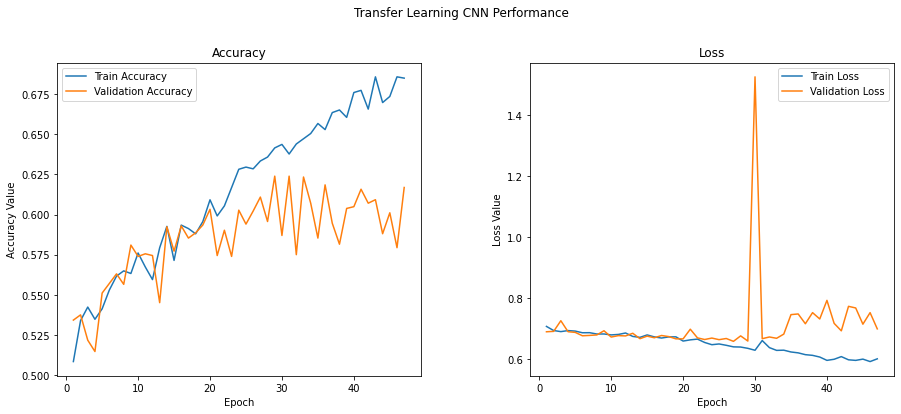

In [8]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
t = f.suptitle('Transfer Learning CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

iterations = len(history.history['accuracy'])
epoch_list = list(range(1,iterations+1))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
#ax1.set_xticks(np.arange(0, 49, 10))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
#ax2.set_xticks(np.arange(0, 49, 10))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [9]:
results = {}
results['epoch_list'] = epoch_list
results['accuracy'] = toString(history.history['accuracy'])
results['val_accuracy'] = toString(history.history['val_accuracy'])
results['val_loss'] = toString(history.history['val_loss'])
results['loss'] = toString(history.history['loss'])

In [10]:
model.save('/content/gdrive/My Drive/Colab Notebooks/Memes Project/best models/finetune_img_aug_vgg16_lr_big_set.h5')

In [11]:
with open('/content/gdrive/My Drive/Colab Notebooks/Memes Project/best models/finetune_img_aug_vgg16_lr_big_set_results.json', 'w') as outfile:
  json.dump(results, outfile)

In [12]:
test_files = glob.glob(data + '/test/*.jpg')
test_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in test_files]
test_imgs = np.array(test_imgs)

test_imgs_scaled = test_imgs.astype('float32')
test_imgs_scaled /= 255 

test_labels = [getDankLevel(fn) for fn in test_files]
test_labels_enc = le.transform(test_labels)

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [13]:
print("Evalutation of model:")
print(model.evaluate(test_imgs_scaled, test_labels_enc))

Evalutation of model:
59/59 [==============================] - 7s 120ms/step - loss: 0.6882 - accuracy: 0.5829
[0.6881790161132812, 0.5828848481178284]
